In [1]:
from NID.datasets import Pinky40
from NID.datasets import CAandEM
from NID.models import DnCNN
from NID.utils import weights_init_kaiming, batch_PSNR

import numpy as np
import scipy.io as sio 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass

import os
import h5py
import random
import cv2
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tensorboardX import SummaryWriter 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

@dataclass
class training_configurations: 
    '''class for storing options of the netowrk training'''
    preprocess: bool = False  
    batchSize: int = 256    # training batch size 
    num_of_layers: int = 17 # number of total layers 
    epochs: int = 3   #number of training epochs 
    milestone: int = 1 # when to decay learning rate 
    lr: float = 1e-3  # initial learning rate 
    outf: str = 'logs' #path of log files 
    mode: str = 'S' #with known noise level (S) or blind training (B)
    noiseL: float = 0.1 # noise level
    val_noiseL: float = 0.1 # nosie level used on validation set 

In [2]:
dataset_train = CAandEM(train=True)
print(type(dataset_train))
dataset_val = CAandEM(train=False)
loader_train = DataLoader(dataset=dataset_train, num_workers=5, 
                         batch_size=256, shuffle=True)

print("# of training samples: %d\n" % len(dataset_train))
print("# of testing samples: %d\n" % len(dataset_val))


the dirname is /data/home/app2139/NID/NID
<class 'NID.datasets.CAandEM'>
the dirname is /data/home/app2139/NID/NID
# of training samples: 449617

# of testing samples: 335



In [3]:
opt = training_configurations()
print(type(opt))
testOpt = opt.outf
print(testOpt)
print(opt.num_of_layers)

<class '__main__.training_configurations'>
logs
17


In [7]:
net = DnCNN(channels=1, num_of_layers=opt.num_of_layers)
# Move to GPU
device_ids = [0]
#initialize weights
file_results = os.path.join(opt.outf, 'net_{}.pth'.format(opt.num_of_layers))
if os.path.exists(file_results):
    print("we entered the if")
    print('use the trained model as the initialization')
    model = net.cuda()
#     model = nn.DataParallel(net, device_ids=device_ids).cuda()
    model.load_state_dict(torch.load(file_results))
    model.eval()
    print(file_results)
else:
    print("we entered the else")
    net.apply(weights_init_kaiming)
    print("we are now doing model = nn.DataParallel...")
    model = nn.DataParallel(net, device_ids=device_ids).cuda()
    print("we exit the else")

noiseL_B=[0,0.3] # ingnored when opt.mode=='S'
criterion = nn.MSELoss(reduction='sum')
criterion.cuda()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=opt.lr)
# training
writer = SummaryWriter(opt.outf)
step = 0
opt.lr = 1e-4

we entered the if
use the trained model as the initialization
logs/net_17.pth


In [9]:
torch.save(model.module.state_dict(), os.path.join(opt.outf, 'net_{}.pth'.format(opt.num_of_layers)))

In [5]:
for epoch in range(opt.epochs):
        if epoch < opt.milestone:
            current_lr = opt.lr
        else:
            current_lr = opt.lr / 10.
        # set learning rate
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        print('learning rate %f' % current_lr)
        # train
        for i, data in enumerate(loader_train, 0):
            # training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            img_train = data
            if opt.mode == 'S':
                noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=opt.noiseL)
            if opt.mode == 'B':
                noise = torch.zeros(img_train.size())
                stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
                for n in range(noise.size()[0]):
                    sizeN = noise[0,:,:,:].size()
                    noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
            imgn_train = img_train + noise
            img_train, imgn_train = Variable(img_train.cuda()), Variable(imgn_train.cuda())
            noise = Variable(noise.cuda())
            out_train = model(imgn_train)
            loss = criterion(out_train, noise) / (imgn_train.size()[0]*2)
            loss.backward()
            optimizer.step()
            # results
            model.eval()
            out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
            psnr_train = batch_PSNR(out_train, img_train, 1.)
            print("[epoch %d][%d/%d] loss: %.4f PSNR_train: %.4f" %
                (epoch+1, i+1, len(loader_train), loss.item(), psnr_train))
            # if you are using older version of PyTorch, you may need to change loss.item() to loss.data[0]
            if step % 10 == 0:
                # Log the scalar values
                writer.add_scalar('loss', loss.item(), step)
                writer.add_scalar('PSNR on training data', psnr_train, step)
            step += 1
        ## the end of each epoch
        model.eval()
        # validate
        psnr_val = 0
        for k in range(len(dataset_val)):
            img_val = torch.unsqueeze(dataset_val[k], 0)
            noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
            imgn_val = img_val + noise
            img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
            out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
            psnr_val += batch_PSNR(out_val, img_val, 1.)
        psnr_val /= len(dataset_val)
        print("\n[epoch %d] PSNR_val: %.4f" % (epoch+1, psnr_val))
        writer.add_scalar('PSNR on validation data', psnr_val, epoch)
        # log the images
#         out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
#         Img = utils.make_grid(img_train.data, nrow=8, normalize=True, scale_each=True)
#         Imgn = utils.make_grid(imgn_train.data, nrow=8, normalize=True, scale_each=True)
#         Irecon = utils.make_grid(out_train.data, nrow=8, normalize=True, scale_each=True)
#         writer.add_image('clean image', Img, epoch)
#         writer.add_image('noisy image', Imgn, epoch)
#         writer.add_image('reconstructed image', Irecon, epoch)
        # save model
        torch.save(model.state_dict(), os.path.join(opt.outf, 'net_{}.pth'.format(opt.num_of_layers)))


learning rate 0.000100
[epoch 1][1/1757] loss: 8.3863 PSNR_train: 22.7862
[epoch 1][2/1757] loss: 8.3137 PSNR_train: 22.7695
[epoch 1][3/1757] loss: 8.1923 PSNR_train: 22.7799
[epoch 1][4/1757] loss: 8.1554 PSNR_train: 22.7283
[epoch 1][5/1757] loss: 8.1365 PSNR_train: 22.7142
[epoch 1][6/1757] loss: 8.0959 PSNR_train: 22.6824
[epoch 1][7/1757] loss: 8.0537 PSNR_train: 22.6575
[epoch 1][8/1757] loss: 7.9651 PSNR_train: 22.6783
[epoch 1][9/1757] loss: 7.9425 PSNR_train: 22.6647
[epoch 1][10/1757] loss: 7.8773 PSNR_train: 22.7013
[epoch 1][11/1757] loss: 7.8301 PSNR_train: 22.6637
[epoch 1][12/1757] loss: 7.7737 PSNR_train: 22.6609
[epoch 1][13/1757] loss: 7.6957 PSNR_train: 22.7052
[epoch 1][14/1757] loss: 7.6393 PSNR_train: 22.6604
[epoch 1][15/1757] loss: 7.5631 PSNR_train: 22.6793
[epoch 1][16/1757] loss: 7.4298 PSNR_train: 22.7089
[epoch 1][17/1757] loss: 7.3513 PSNR_train: 22.6637
[epoch 1][18/1757] loss: 7.2466 PSNR_train: 22.6798
[epoch 1][19/1757] loss: 7.1262 PSNR_train: 22.668

In [6]:
print(len(dataset_val))

335


In [7]:
psnr_val = 0
for k in range(len(dataset_val)):
            img_val = torch.unsqueeze(dataset_val[k], 0)
            noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
            imgn_val = img_val + noise
            img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
            out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
            psnr_val += batch_PSNR(out_val, img_val, 1.)
psnr_val /= len(dataset_val)
print(psnr_val)

34.91685201874206


In [8]:
#TEST ON REAL DATA:

data_path = os.path.join(dataset_train.root, 'testdata')
real_data = sio.loadmat(os.path.join(data_path, 'real_2pdata.mat'))
A2p = real_data['A']
A2p_corr = real_data['A_corr']
A2p_raw = real_data['A_raw']
print(A2p_raw.shape)

(60, 80, 38)


In [9]:
def plot_2p_results(neuron_id, cmap='jet'): 
#     img_raw = A_corr[:, :, neuron_id]
    img_raw = A2p_raw[:,:,neuron_id]

    noise = img_raw.std()
    img_raw = img_raw[np.newaxis, np.newaxis, ...] / noise * 0.1
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    
    img_ai = A2p[:, :, neuron_id].squeeze()
    img_ai_raw = A2p_raw[:,:,neuron_id].squeeze()
    img_diff= img_ai_raw.squeeze() - img_ai
    
    
    
        
    #AMOL CODE
    print("NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE")
    img_raw_orig = A2p_raw[:, :, neuron_id]
    img_denoised_orig = img_denoised * noise / 0.1
    img_denoised_orig = img_denoised_orig
    
#     plt.figure()
#     plt.imshow(img_raw_orig)
#     plt.figure()
#     plt.imshow(img_denoised_orig)
    
    
    
    
    img_diff = img_diff / noise * 0.1
    print(img_diff.shape)
    imgs = [img_raw.squeeze(), img_denoised.squeeze(), 
            img_output.squeeze(), img_ai/noise*0.1, img_diff]
#     imgs = [img_raw_orig.squeeze(), img_denoised_orig.squeeze(), \
#                img_output.squeeze(), img_ai/noise*0.1, img_diff]
    titles = ['unconstrained $a_i$', 'denoised $a_i$', 'residual', 'CNMF $a_i$', 'difference']
#     fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    plt.figure(figsize=(12, 8))
    vlims = [[-0.1,1], [-0.1,1], [-0.2, 0.2], [-0.1,1], [-0.2, 0.2]]
    for i, img, title, vlim in zip(range(len(imgs)), imgs, titles, vlims): 
        plt.subplot(2,5, i+1)
        im = plt.imshow(img, cmap=cmap, clim=vlim)
        plt.colorbar()
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.title(title)
#         plt.colorbar(im, cax=cax)
        
    
    
#     plt.tight_layout()

    SNRvalue = np.var(img_denoised)
    print(SNRvalue)
    
    #END OF AMOL CODE
    
    imgs = imgs[0:2]
    labels = ['raw image', 'denoised image']
#     plt.figure(figsize=(5, 8))
    plt.subplot(2,2,3)
    for i, img, label in zip(range(len(imgs)), imgs, labels): 
        __ = plt.hist(img.flatten(), bins=np.linspace(-0.2,1, 100), 
                     label=label)
        plt.yscale('log')
        plt.legend()
   
        
    plt.subplot(2,2, 4)
    plt.plot(img_raw.ravel(), img_denoised.ravel(), '.')
    plt.plot([-0.5, 2], [-0.5,2], c='r')
    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])
    plt.xlabel('raw pixel values')
    plt.ylabel('denoised pixel values')
    plt.tight_layout()
    
    
    
#     plt.savefig('{} SNR Neuron Data ID {}.jpeg'.format(SNRvalue, neuron_id))
    return img_raw, img_denoised

In [10]:
def plot_2p_results2(neuron_id, cmap='jet'): 
#     img_raw = A_corr[:, :, neuron_id]
    img_raw = A2p_raw[:,:,neuron_id]

    noise = img_raw.std()
    img_raw = img_raw[np.newaxis, np.newaxis, ...] / noise * 0.1
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A2p[:, :, neuron_id].squeeze()
    img_ai_raw = A2p_raw[:,:,neuron_id].squeeze()
    img_diff= img_ai_raw.squeeze() - img_ai
    
    
    
        
    #AMOL CODE
    print("NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE")
    img_raw_orig = A2p_raw[:, :, neuron_id]
    img_denoised_orig = img_denoised * noise / 0.1
    img_denoised_orig = img_denoised_orig
    
#     plt.figure()
#     plt.imshow(img_raw_orig)
#     plt.figure()
#     plt.imshow(img_denoised_orig)
    
    
    
    
    img_diff = img_diff / noise * 0.1
    print(img_diff.shape)
    imgs = [img_raw.squeeze(), img_denoised.squeeze(), 
            img_output.squeeze(), img_ai/noise*0.1, img_diff]
#     imgs = [img_raw_orig.squeeze(), img_denoised_orig.squeeze(), \
#                img_output.squeeze(), img_ai/noise*0.1, img_diff]
    titles = ['unconstrained $a_i$', 'denoised $a_i$', 'residual', 'CNMF $a_i$', 'difference']
#     fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    plt.figure(figsize=(12, 8))
    vlims = [[-0.1,1], [-0.1,1], [-0.2, 0.2], [-0.1,1], [-0.2, 0.2]]
    for i, img, title, vlim in zip(range(len(imgs)), imgs, titles, vlims): 
        plt.subplot(2,5, i+1)
        im = plt.imshow(img, cmap=cmap, clim=vlim)
        plt.colorbar()
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.title(title)
#         plt.colorbar(im, cax=cax)
        
#     plt.savefig('Neuron Data {}'.format(neuron_id))
#     plt.tight_layout()

    
    
    #END OF AMOL CODE
    
    imgs = imgs[0:2]
    labels = ['raw image', 'denoised image']
#     plt.figure(figsize=(5, 8))
    plt.subplot(2,2,3)
    for i, img, label in zip(range(len(imgs)), imgs, labels): 
        __ = plt.hist(img.flatten(), bins=np.linspace(-0.2,1, 100), 
                     label=label)
        plt.yscale('log')
        plt.legend()

    plt.subplot(2,2, 4)
    plt.plot(img_raw.ravel(), img_denoised.ravel(), '.')
    plt.plot([-0.5, 2], [-0.5,2], c='r')
    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])
    plt.xlabel('raw pixel values')
    plt.ylabel('denoised pixel values')
    plt.tight_layout()

    plt.savefig('Neuron Data {}'.format(neuron_id))
    
    return img_raw, img_denoised

NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.009259538012599574


/data/home/app2139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.009565033669296365
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.00945797260505427
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.009073486450814579
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.009388082587304215
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.008558889785040944
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.00873674102305956
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.008549401448526783
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.008057117095346887
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.008041825416832361
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.008214347305092079
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.007567483851493771
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.007997220489038993
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.008078216684510451
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIG

/data/home/app2139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.006283154310641014
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.00801842777185217
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.006509595588703381
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.006511736749192193
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.0060644663630147425
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.005785833139006359
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.005852997657509046
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.005924123922173412
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.00634007055918677
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.006335028034948905
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.005211529458009042
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.004686344906477403
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.00572955700604113
NOW WE COMPARE ORIGINAL IMAGE TO NEW FIG

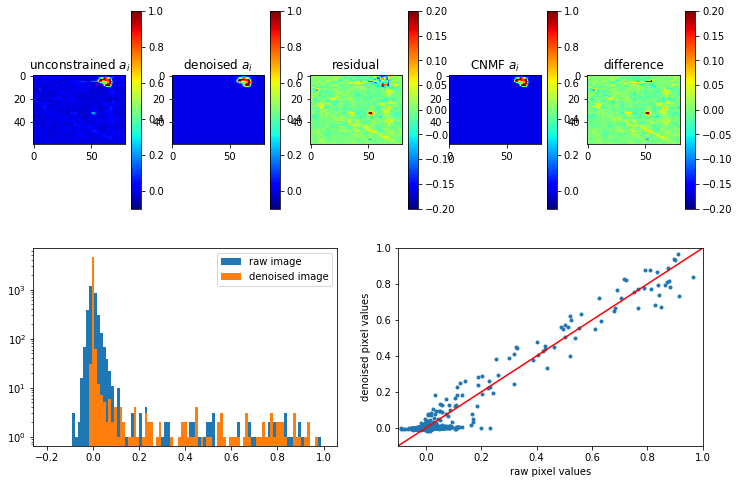

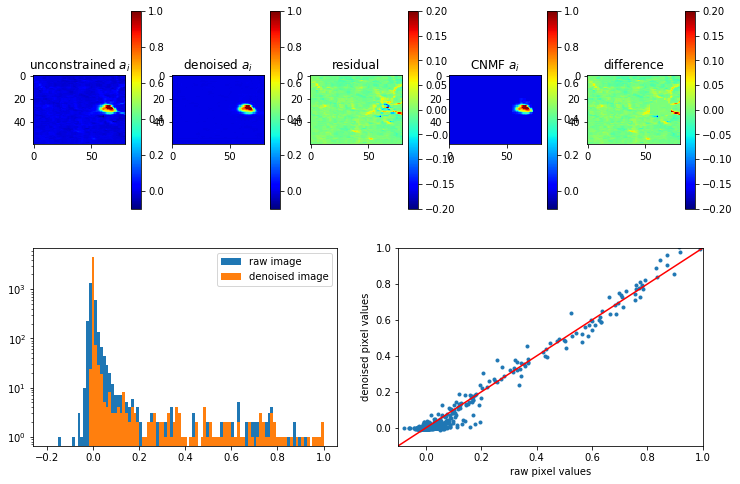

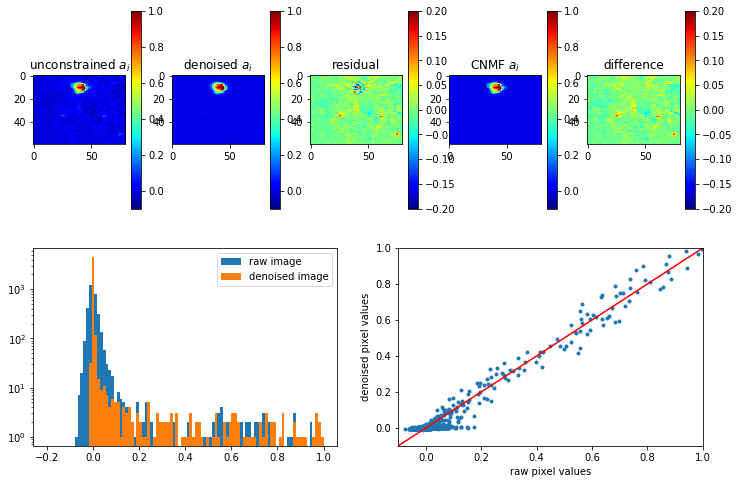

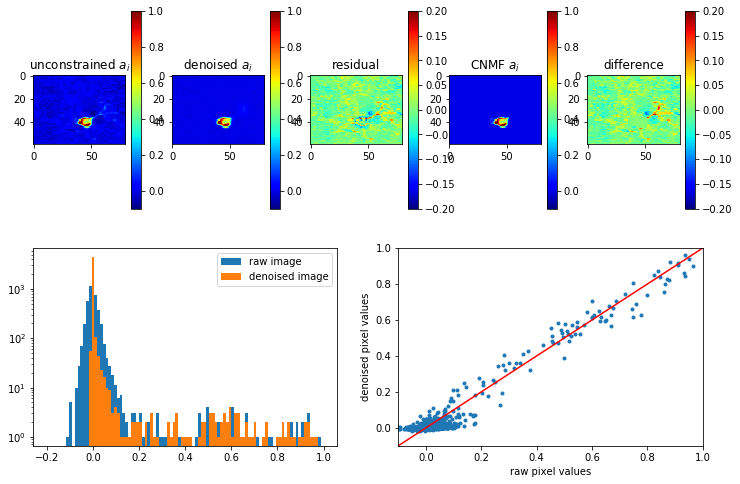

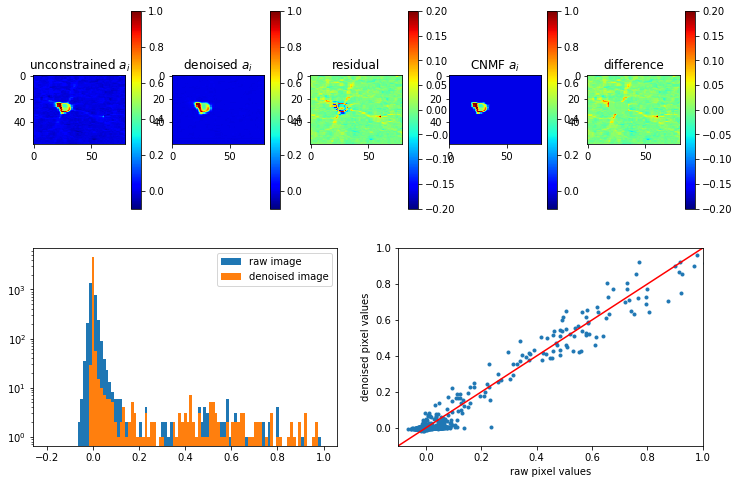

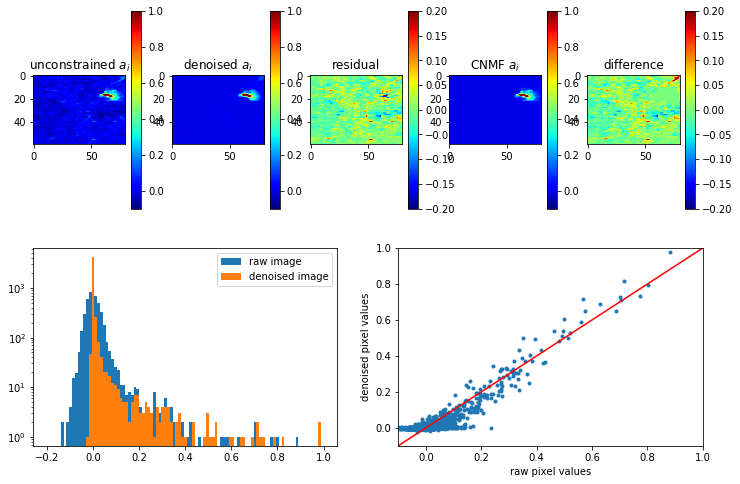

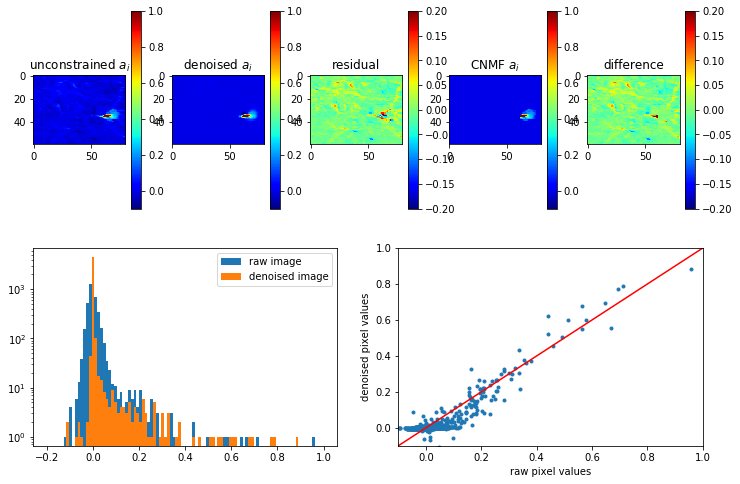

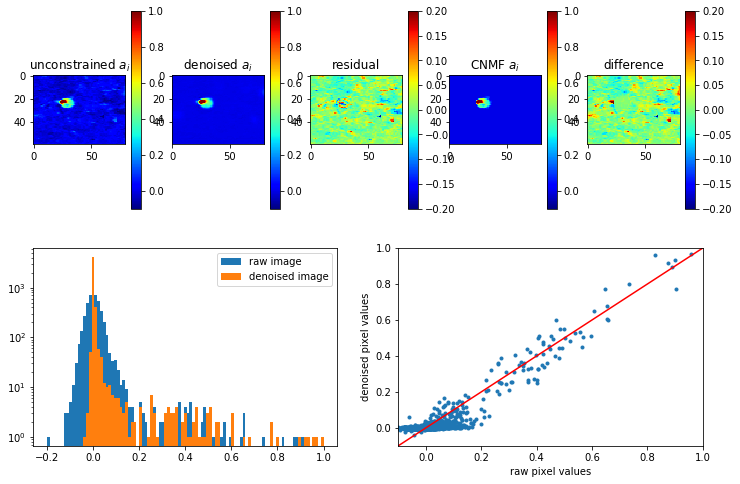

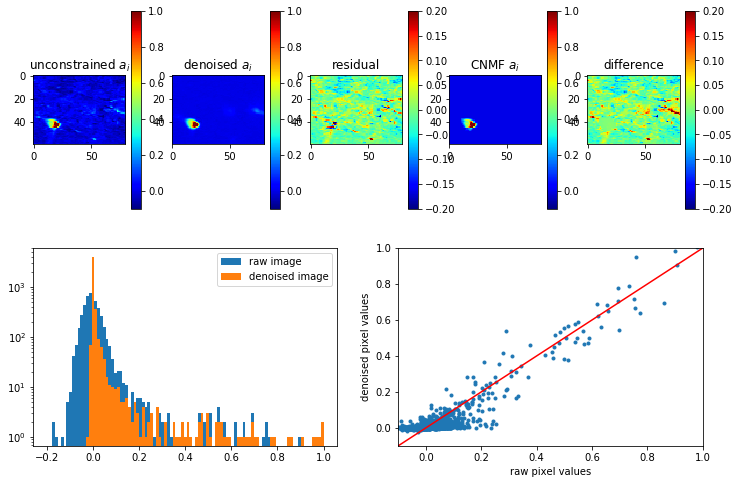

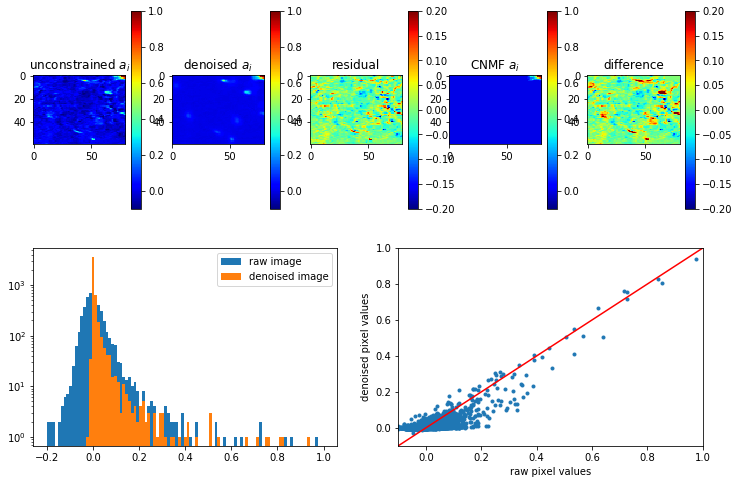

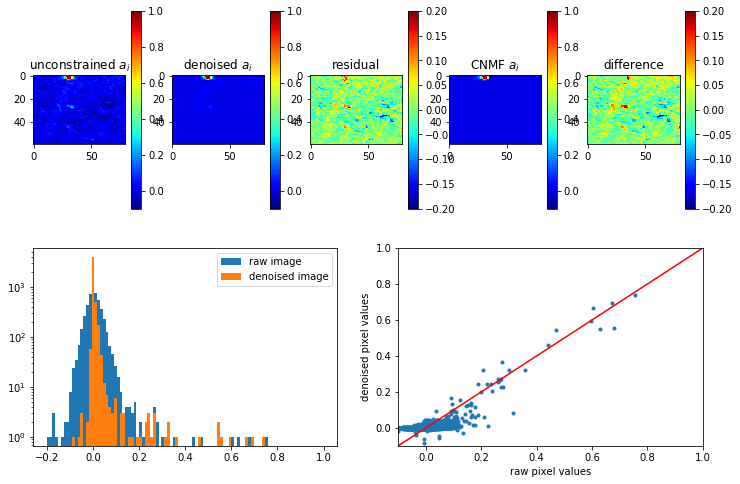

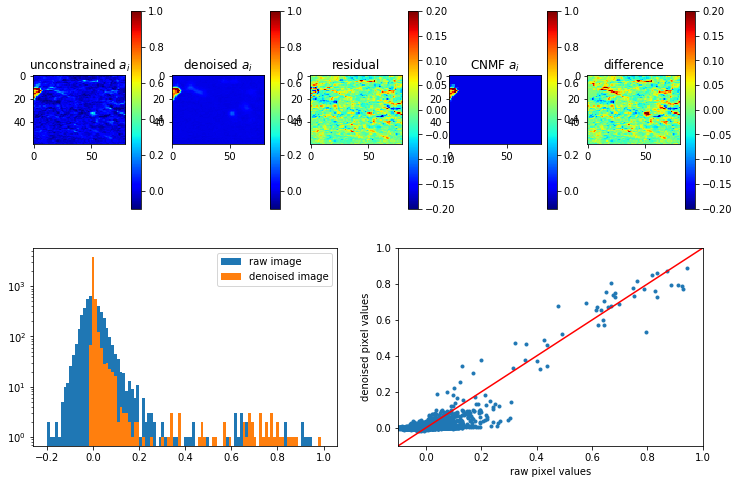

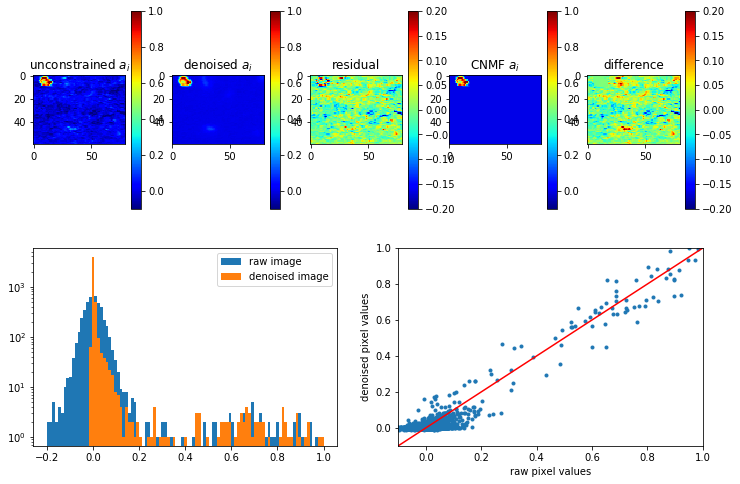

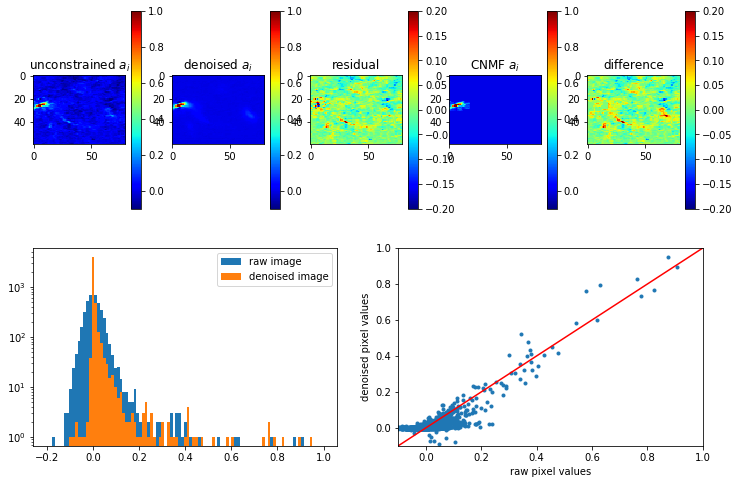

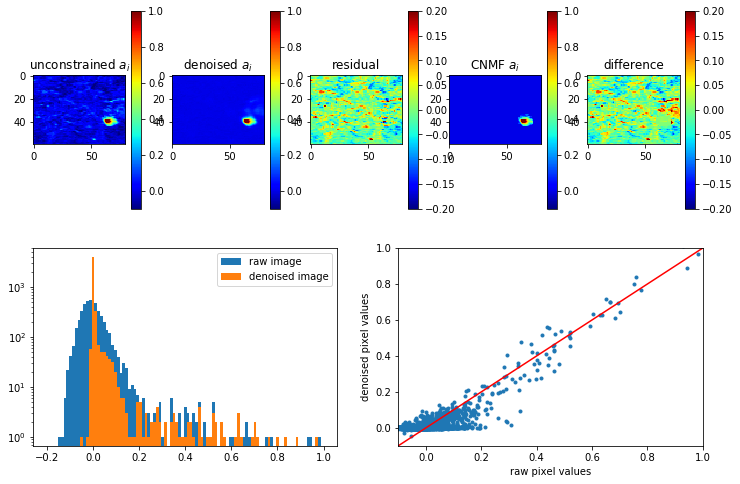

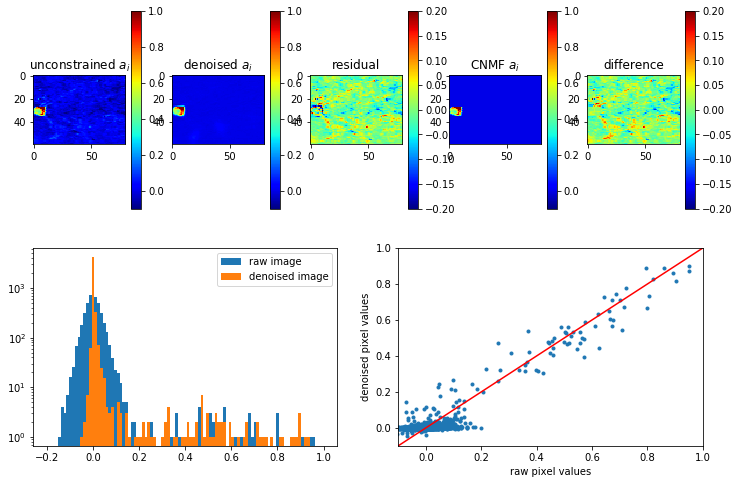

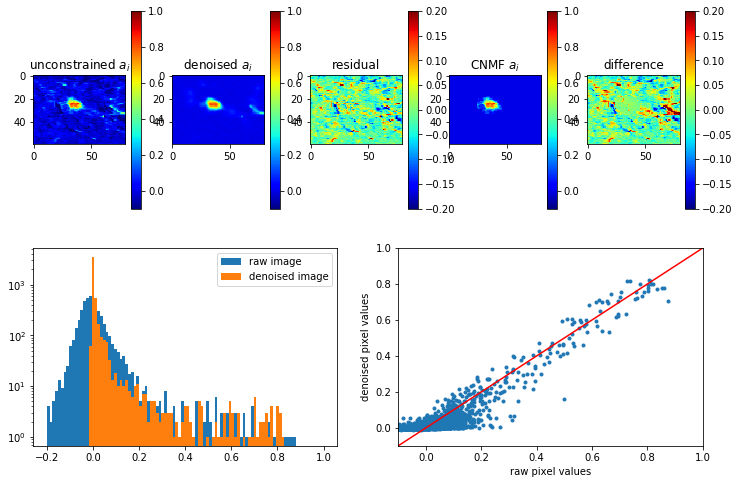

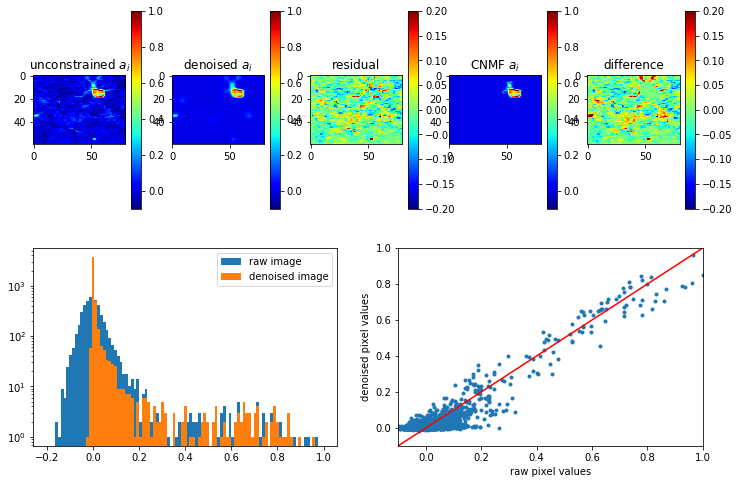

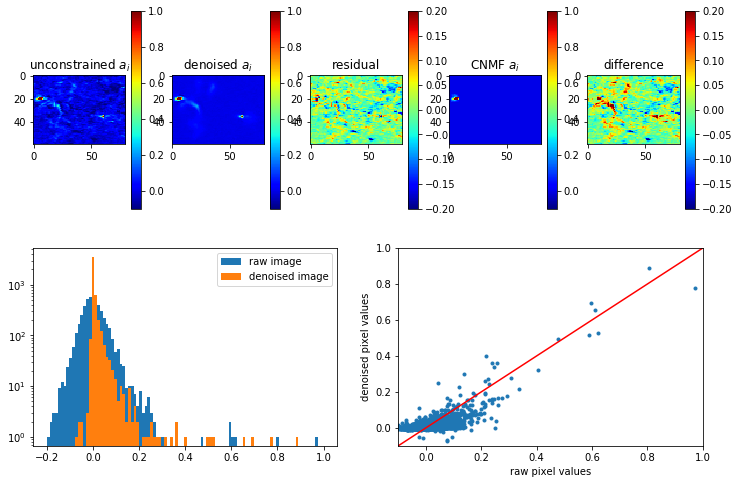

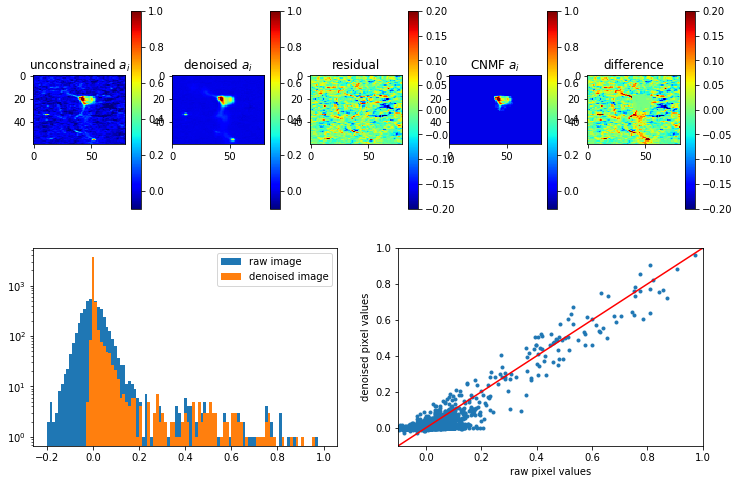

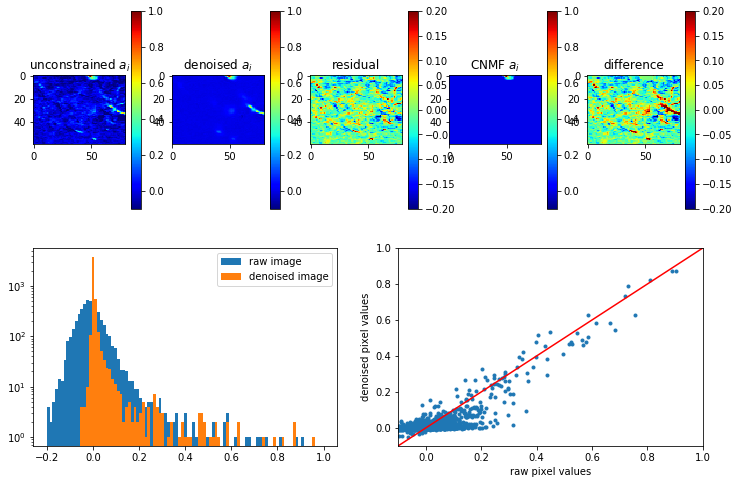

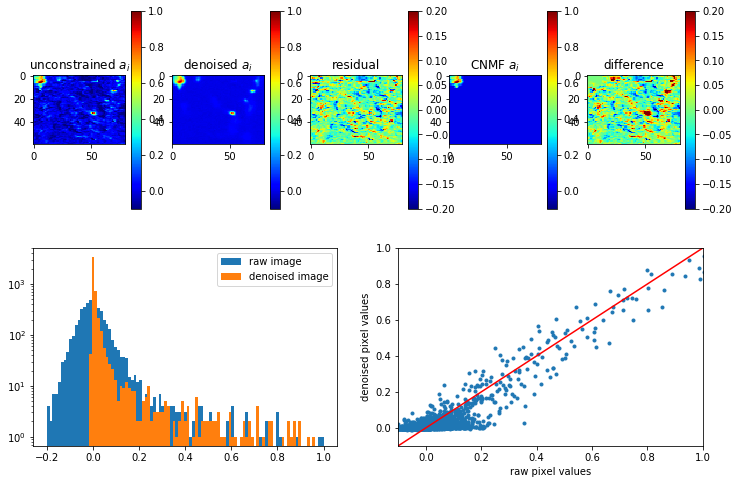

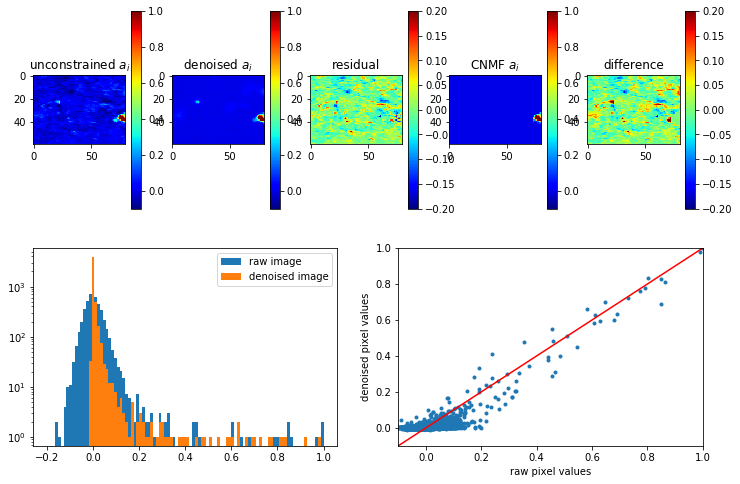

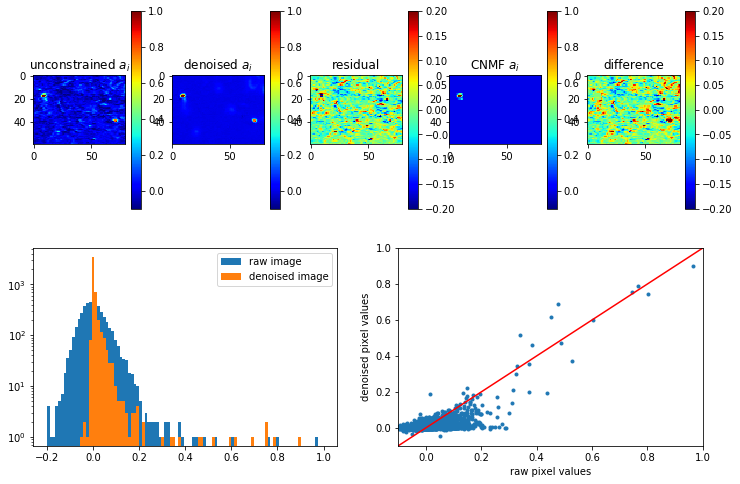

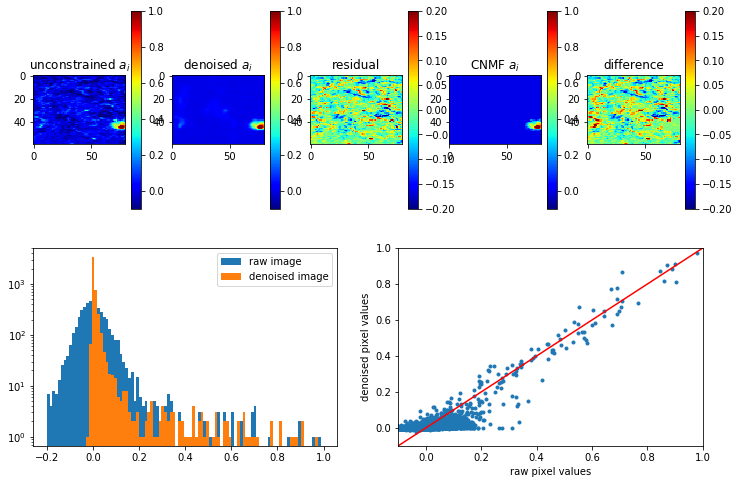

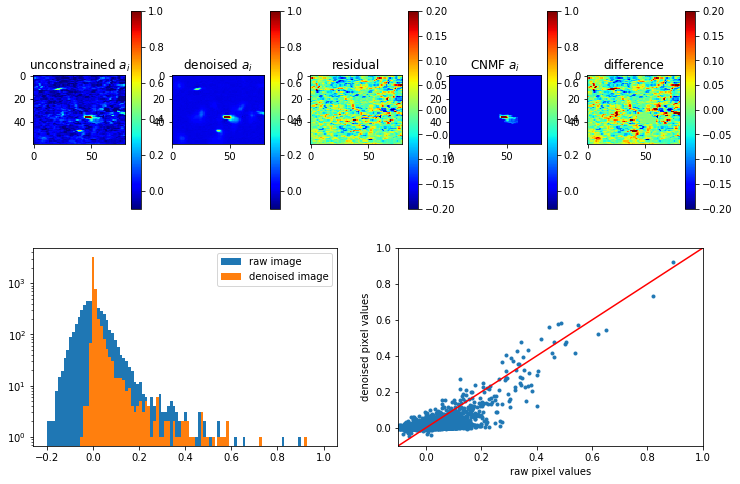

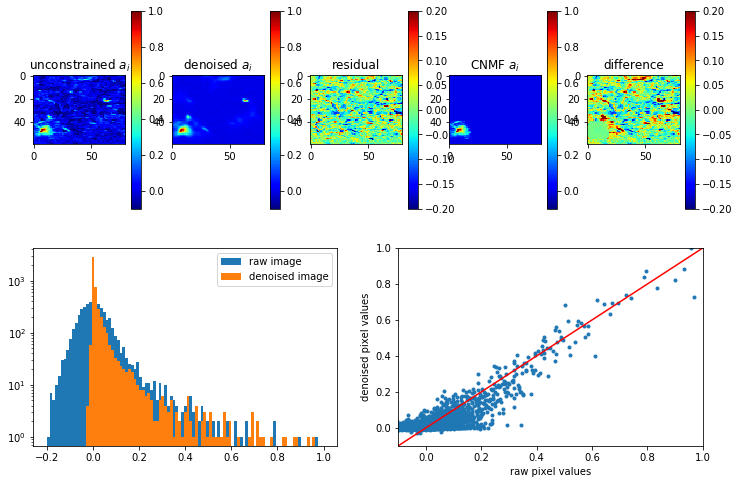

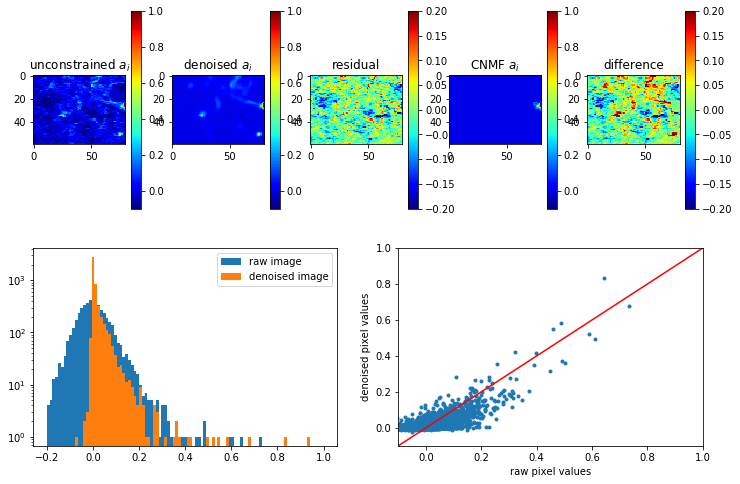

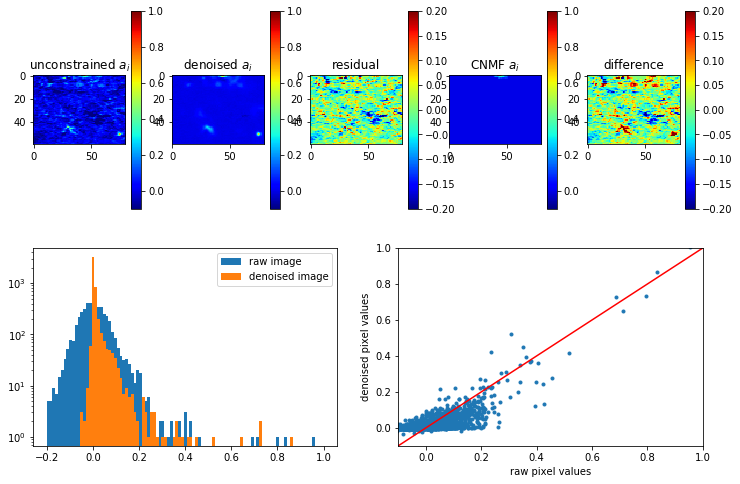

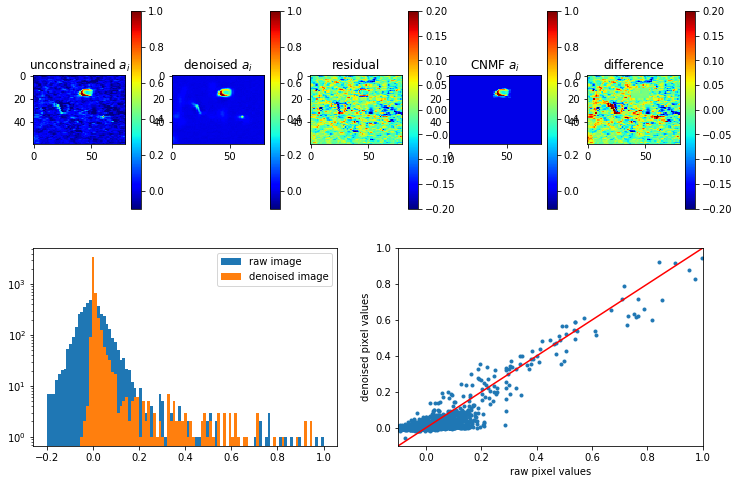

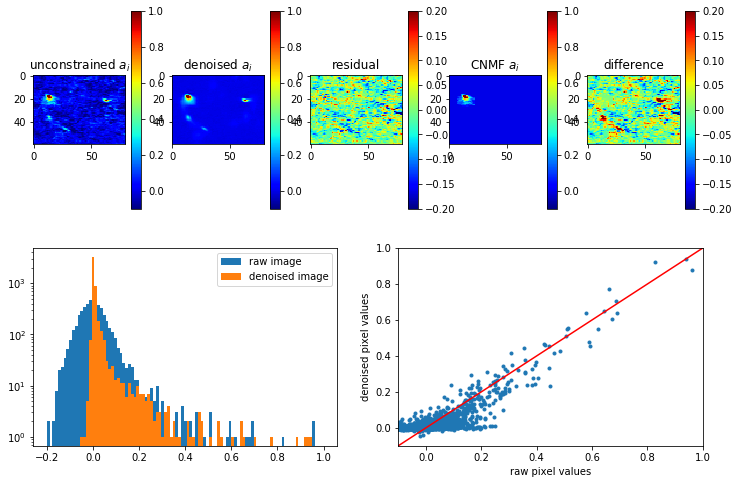

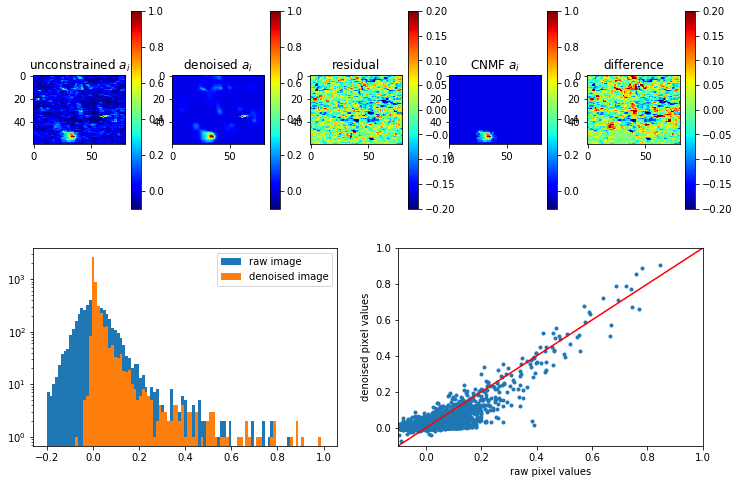

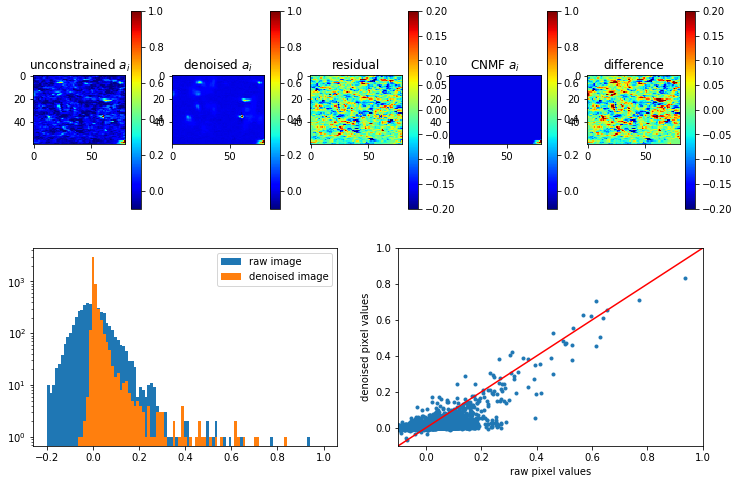

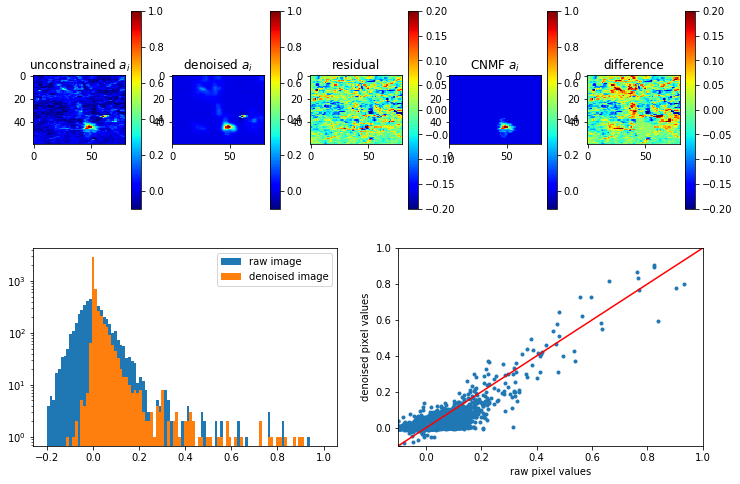

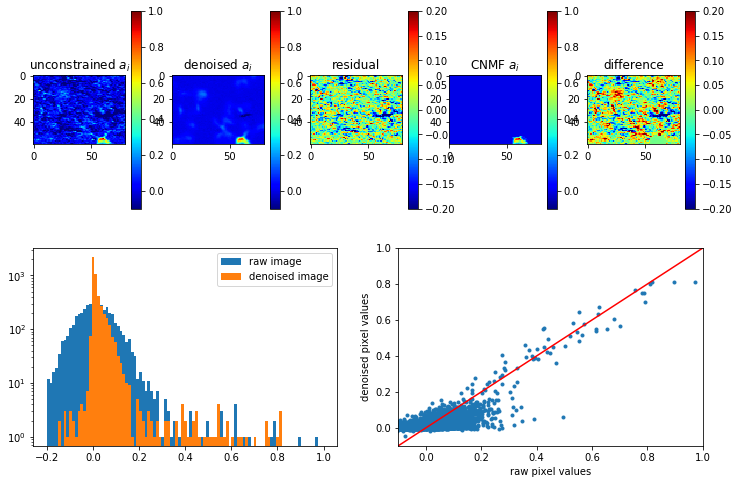

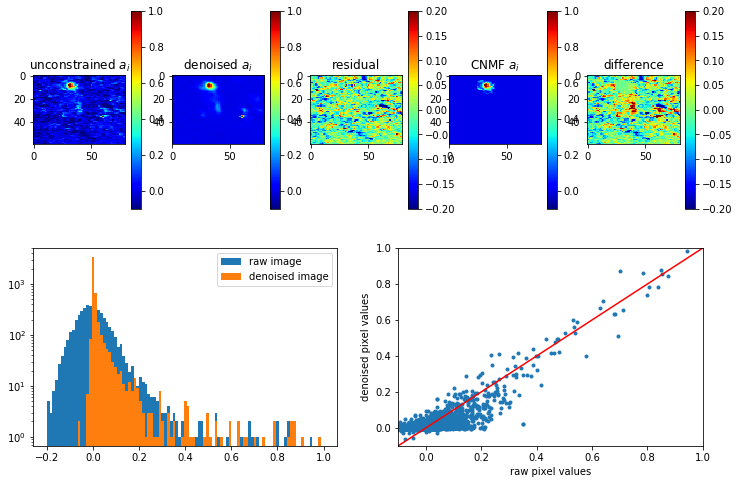

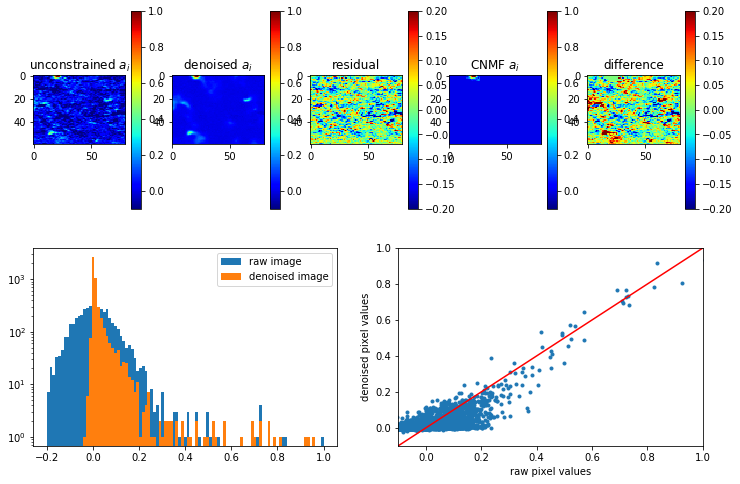

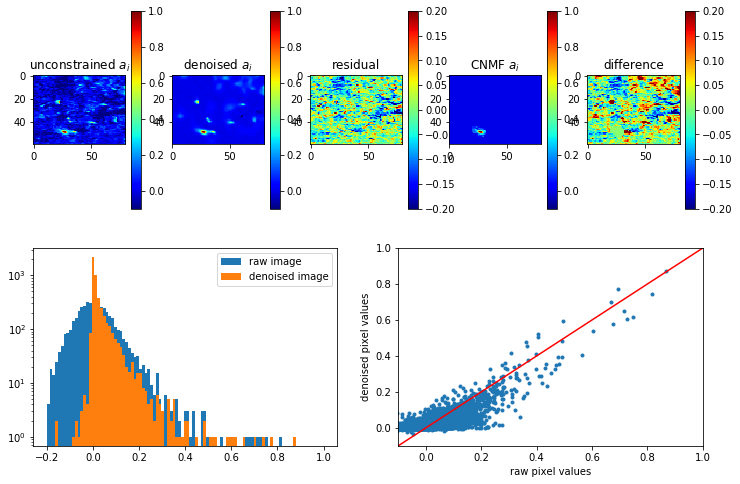

In [13]:
for i in range(38):
    img_raw, img_denoised = plot_2p_results(i)

NOW WE COMPARE ORIGINAL IMAGE TO NEW FIGURE
(60, 80)
0.006554382078200214


/data/home/app2139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


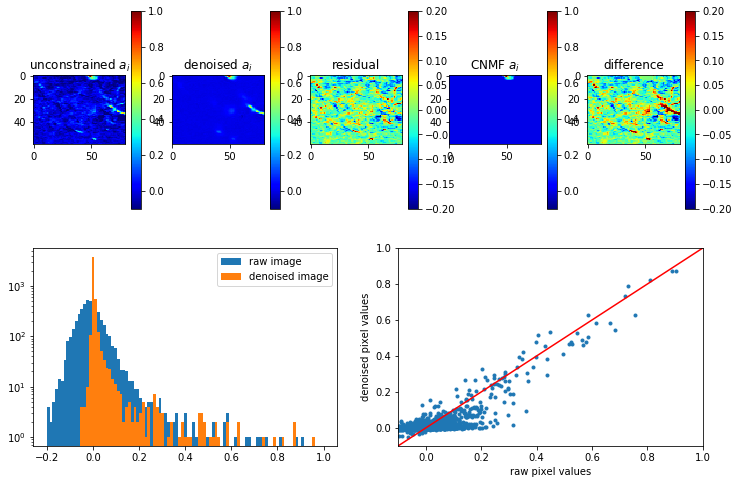

In [11]:
a, b = plot_2p_results(20)

Text(0.5, 1.0, 'NN-denoiser')

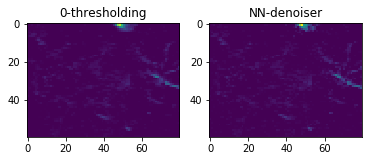

In [13]:
plt.subplot(121)
plt.imshow((img_raw * (img_raw>0)).squeeze(), clim=[0,1])
plt.title('0-thresholding')
plt.subplot(122)
plt.imshow(img_denoised.squeeze(), clim=[0,1])
plt.title('NN-denoiser')

In [9]:
#We can test the baylor data

In [27]:
real_data = sio.loadmat(os.path.join(data_path, 'baylor_data.mat'))
A = real_data['A']
A_corr = real_data['A_corr']
A_em = real_data['A_em']

In [28]:
def plot_baylor_results(neuron_id, plane_id, cmap='jet'): 
    img_raw = A_corr[:, :, plane_id, neuron_id].reshape(1,1, 58, 129)
    noise = img_raw[img_raw!=0].std()
    img_raw = img_raw / img_raw.max() 
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A[:, :, plane_id, neuron_id].squeeze()
    img_pi = A_em[:,:,plane_id, neuron_id].squeeze()
    
    imgs = [img_pi/img_pi.max(), img_ai/img_ai.max(), img_raw.squeeze(), img_denoised.squeeze(), img_output.squeeze()]
    titles = ['EM footprint', '2P footprint', 'corr. image', 'denoised corr. image', 'residual']
    fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    for img, title, ax in zip(imgs, titles, axs): 
        im = ax.imshow(img, cmap=cmap, clim=[-0.1, 0.5])
        ax.set_ylabel(title)
    

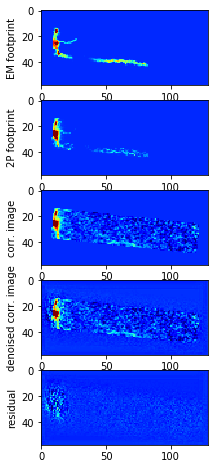

In [29]:
plot_baylor_results(5,2)

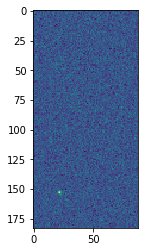

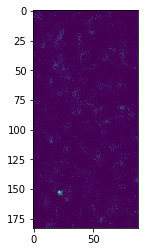

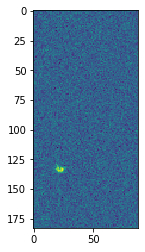

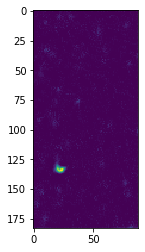

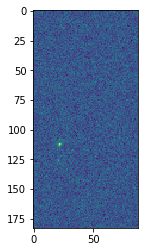

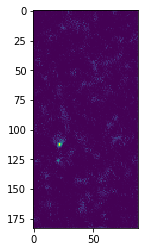

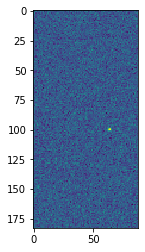

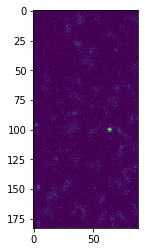

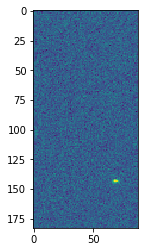

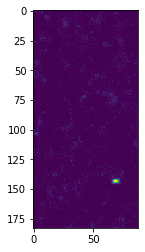

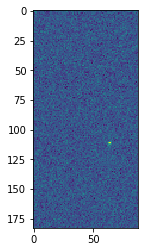

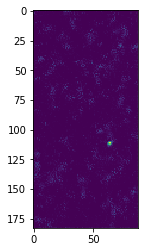

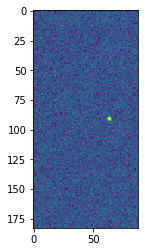

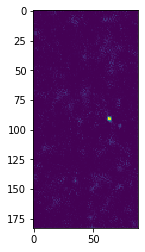

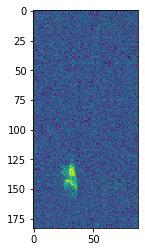

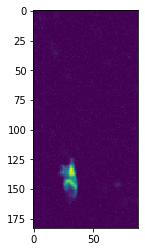

KeyboardInterrupt: 

In [11]:
#Here we visualize how well the model actually performs on the test data that we defined for it
for k in range(len(dataset_train)):
    img_val = torch.unsqueeze(dataset_val[k], 0)
    noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
    imgn_val = img_val + noise
    img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
    out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
    imgn_valCPU = imgn_val.detach().cpu().numpy()
    imgn_valCPU = imgn_valCPU.squeeze()
    out_valCPU = out_val.detach().cpu().numpy()
    out_valCPU = out_valCPU.squeeze()
    
    plt.figure()
    plt.imshow(imgn_valCPU)
    plt.figure()
    plt.imshow(out_valCPU)
    plt.show()
    input()
#     psnr_val += batch_PSNR(out_val, img_val, 1.)
# psnr_val /= len(dataset_val)